In [1]:
"""
Author        : Aditya Jain
Date Started  : July 5, 2022
About         : Creating a webdataset
"""

'\nAuthor        : Aditya Jain\nDate Started  : July 5, 2022\nAbout         : Creating a webdataset\n'

In [3]:
import json
import os
import random

from PIL import Image
from torchvision import transforms
import PIL
import numpy as np
import pandas as pd
import torch
import webdataset as wds
import matplotlib.pyplot as plt

#### Input variables

In [3]:
dataset_dir         = '/home/mila/a/aditya.jain/scratch/GBIF_Data/moths_uk/'
dataset_filename    = '/home/mila/a/aditya.jain/mothAI/classification_moths/data/01-uk-val-split.csv'
label_filename      = '/home/mila/a/aditya.jain/mothAI/classification_moths/data/uk_numeric_labels.json' 
img_resize          = 500
webdataset_patern   = '/home/mila/a/aditya.jain/scratch/GBIF_Data/webdataset_moths_uk/val/val-500-%06d.tar'
max_shard_size      = 100*1024*1024

#### Creating webdataset

In [40]:
dataset_df = pd.read_csv(dataset_filename)
label_list = json.load(open(label_filename))

transformer = transforms.Compose([
                transforms.Resize((img_resize, img_resize))])

sink        = wds.ShardWriter(webdataset_patern, max_shard_size)
i           = 0

for _, row in dataset_df.iterrows():
    image_path = dataset_dir + row['family'] + '/' + row['genus'] + '/' + row['species'] + '/' + row['filename']
    
    if not os.path.isfile(image_path):
        print(f'File {image_path} not found')
        continue
        
    # check issue with image opening; completely corrupted
    try:
        image = Image.open(image_path)
        image = image.convert('RGB')
    except PIL.UnidentifiedImageError:
        print(f'Unidentified Image Error on file {image_path}')
        continue
    except OSError:
        print(f'OSError Error on file {image_path}')
        continue    
        
    # check for partial image corruption
    try:
        image = transformer(image) 
    except:
        print(f'Partial corruption of file {image_path}')
        continue    
    
    fpath        = row['family'] + '/' + row['genus'] + '/' + row['species'] + '/' + row['filename']
    fpath        = os.path.splitext(fpath)[0].lower()
    
    species_list = label_list['species_list']
    label        = row['species']    
    label        = species_list.index(label)
        
    sample = {
      '__key__': fpath,
      'jpg': image,
      'cls': label
    }

    sink.write(sample)
    i+=1
    if i==5000:
        break    
    
sink.close()

# writing /home/mila/a/aditya.jain/scratch/GBIF_Data/webdataset_moths_uk/val/val-500-000000.tar 0 0.0 GB 0
<PIL.Image.Image image mode=RGB size=500x500 at 0x7F0179CAF490>
<class 'PIL.Image.Image'>


##### Testing

In [12]:
image_path = '/home/mila/a/aditya.jain/scratch/GBIF_Data/moths_uk-denmark/Sphingidae/Hyles/Hyles gallii/3013999245.jpg'
image = Image.open(image_path)
          
transformer = transforms.Compose([
                transforms.Resize((500, 500))])

try:
    image = transformer(image) 
except:
    print(f'Partial corruption of file {image_path}')


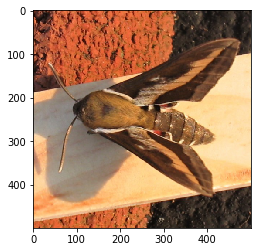

In [13]:
plt.imshow(image)